In [1]:
from jupyterthemes import jtplot
from tensorflow import set_random_seed
set_random_seed(42)
jtplot.style()
# Constantes
SEED = 42
m = 64
tau = 1
delta = 2

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from keras import regularizers
from tensorflow import keras
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [3]:
from Funciones import GenersConjuntos
from Funciones import plot_history

In [4]:
def ModMLP(show=True): # Modelo de la red neuronal a utilizar
    inputs = keras.Input(shape=(m))
    x = layers.Dense(64, activation='sigmoid')(inputs)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(delta, activation='linear')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='forecasting')
    
    if(show):
        model.summary()
    
    return model

<h3> Lectura y analisis de la serie de tiempo </h3>

Para comenzar se lee la serie de tiempo desde el archivo csv

In [5]:
TS = pd.read_csv('TimesSeries\Electric_Production.csv')

In [6]:
TS.info() # Se reviza que la serie de tiempo no tenga nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
DATE     397 non-null object
Value    397 non-null float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


La serie de tiempo es tomada desde la columna value

In [7]:
serie = TS.Value

Se pueden revizar su media, su maximo, su minimo, y su promedio

In [8]:
print('Media:', serie.mean())
print('Maximo:', serie.max())
print('Minimo:', serie.min())
print('STD:', serie.std())

Media: 88.84721763224182
Maximo: 129.4048
Minimo: 55.3151
STD: 15.387833664730902


La serie es convertiza a numpy array para un mejor manejo, a su vez es ploteada para observar su forma

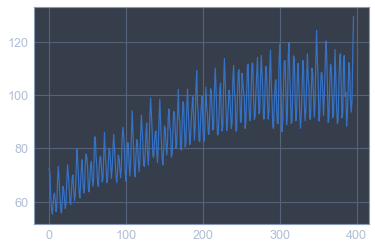

In [9]:
serie = np.array(serie)
plt.plot(serie)
plt.show()

Posteriormente se estandariza la serie y se obtienen los conjuntos de datos con los cuales se ha de entrenar la red

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test=  GenersConjuntos(serie, 0.3, 0.2)

In [11]:
X_val.shape

(47, 64)

<h3> Añadir ruido al train_set </h3>

Para añadir ruido al conjunto de entrenamiento

In [12]:
def Noise(muestras, sigma, mean):
    N = np.random.normal(mean, sigma, size=(muestras))
    return N

In [67]:
#np.random.seed(SEED)
A = Noise(X_train.shape,0.01,0)
A/=abs(A).max()
A*=0.0003
maximo = abs(A)
print('MaximoAbs:', maximo.max())
print('Media:', A.mean())
print('Maximo:', A.max())
print('Minimo:', A.min())
print('STD:', A.std())
A.shape

MaximoAbs: 0.0003
Media: 1.9661256137878864e-07
Maximo: 0.0003
Minimo: -0.00028997675281047965
STD: 7.476468083028857e-05


(185, 64)

In [68]:
X_train_e = X_train + A

print('Media:', X_train_e.mean())
print('Maximo:', X_train_e.max())
print('Minimo:', X_train_e.min())
print('STD:', X_train.std())

print('Media:', X_train.mean())
print('Maximo:', X_train.max())
print('Minimo:', X_train.min())
print('STD:', X_train.std())


Media: 0.07134906735329787
Maximo: 2.3041546255025627
Minimo: -2.1820508919422865
STD: 0.9092079024171517
Media: 0.07134887074073648
Maximo: 2.3039215019814105
Minimo: -2.1818814916347007
STD: 0.9092079024171517


<h3> Diseño y entrenamiento de la red neuronal </h3>

In [69]:
model = ModMLP()

Model: "forecasting"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_30 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 514       
Total params: 46,018
Trainable params: 46,018
Non-trainable params: 0
_________________________________________________________________


Una vez que el modelo esta creado se compila y se entrena.

En la compilación se utiliza como funcion de perdida el Error cuadratico medio en convinacion con el gradiente estocastico, el tercer parametro son las metricas en este caso se utilizan el error absoluto medio, el error cuadratico medio y accuracy, aunque la ultima no es una buena referencia cuando se realiza prediccion de series de tiempo (forcasting) es más comun su utilización en clasificación.

In [70]:
model.compile(loss="mean_squared_error", optimizer="sgd", metrics=['mae', 'mse','accuracy'])

In [71]:
#callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_e, y_train,
                    batch_size=64,
                    #callbacks=[callback],
                    epochs=2000,
                    validation_data=(X_val, y_val))

test_scores = model.evaluate(X_test, y_test, batch_size=32)
print('Test loss:', test_scores[0])
print('Test mae:', test_scores[1])
print('Test mse:', test_scores[2])
print('Test acc:', test_scores[3])

Train on 185 samples, validate on 47 samples
Epoch 1/2000
185/185 [==============================] - 0s 1ms/sample - loss: 0.7130 - mean_absolute_error: 0.6835 - mean_squared_error: 0.7130 - acc: 0.5189 - val_loss: 0.4950 - val_mean_absolute_error: 0.5649 - val_mean_squared_error: 0.4950 - val_acc: 0.5745
Epoch 2/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.5878 - mean_absolute_error: 0.6230 - mean_squared_error: 0.5878 - acc: 0.6162 - val_loss: 0.4269 - val_mean_absolute_error: 0.5295 - val_mean_squared_error: 0.4269 - val_acc: 0.7872
Epoch 3/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.5204 - mean_absolute_error: 0.5905 - mean_squared_error: 0.5204 - acc: 0.7297 - val_loss: 0.3797 - val_mean_absolute_error: 0.5040 - val_mean_squared_error: 0.3797 - val_acc: 0.8085
Epoch 4/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.4680 - mean_absolute_error: 0.5649 - mean_squared_error: 0.4680 - acc: 0.7784 - val

Epoch 32/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0990 - mean_absolute_error: 0.2537 - mean_squared_error: 0.0990 - acc: 0.9081 - val_loss: 0.0633 - val_mean_absolute_error: 0.2052 - val_mean_squared_error: 0.0633 - val_acc: 0.9149
Epoch 33/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0961 - mean_absolute_error: 0.2484 - mean_squared_error: 0.0961 - acc: 0.9081 - val_loss: 0.0623 - val_mean_absolute_error: 0.2050 - val_mean_squared_error: 0.0623 - val_acc: 0.9149
Epoch 34/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0928 - mean_absolute_error: 0.2461 - mean_squared_error: 0.0928 - acc: 0.9081 - val_loss: 0.0604 - val_mean_absolute_error: 0.2007 - val_mean_squared_error: 0.0604 - val_acc: 0.9149
Epoch 35/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0905 - mean_absolute_error: 0.2416 - mean_squared_error: 0.0905 - acc: 0.9081 - val_loss: 0.0590 - val_mean_absolute_error

Epoch 63/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0587 - mean_absolute_error: 0.1899 - mean_squared_error: 0.0587 - acc: 0.9081 - val_loss: 0.0466 - val_mean_absolute_error: 0.1705 - val_mean_squared_error: 0.0466 - val_acc: 0.9149
Epoch 64/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0583 - mean_absolute_error: 0.1891 - mean_squared_error: 0.0583 - acc: 0.9081 - val_loss: 0.0468 - val_mean_absolute_error: 0.1708 - val_mean_squared_error: 0.0468 - val_acc: 0.9149
Epoch 65/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0586 - mean_absolute_error: 0.1895 - mean_squared_error: 0.0586 - acc: 0.9081 - val_loss: 0.0465 - val_mean_absolute_error: 0.1704 - val_mean_squared_error: 0.0465 - val_acc: 0.9149
Epoch 66/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0580 - mean_absolute_error: 0.1891 - mean_squared_error: 0.0580 - acc: 0.9081 - val_loss: 0.0462 - val_mean_absolute_error

185/185 [==============================] - 0s 108us/sample - loss: 0.0510 - mean_absolute_error: 0.1759 - mean_squared_error: 0.0510 - acc: 0.9081 - val_loss: 0.0454 - val_mean_absolute_error: 0.1672 - val_mean_squared_error: 0.0454 - val_acc: 0.9149
Epoch 94/2000
185/185 [==============================] - ETA: 0s - loss: 0.0531 - mean_absolute_error: 0.1839 - mean_squared_error: 0.0531 - acc: 0.90 - 0s 113us/sample - loss: 0.0510 - mean_absolute_error: 0.1765 - mean_squared_error: 0.0510 - acc: 0.9081 - val_loss: 0.0450 - val_mean_absolute_error: 0.1672 - val_mean_squared_error: 0.0450 - val_acc: 0.9149
Epoch 95/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0505 - mean_absolute_error: 0.1758 - mean_squared_error: 0.0505 - acc: 0.9081 - val_loss: 0.0448 - val_mean_absolute_error: 0.1670 - val_mean_squared_error: 0.0448 - val_acc: 0.9149
Epoch 96/2000
185/185 [==============================] - 0s 105us/sample - loss: 0.0505 - mean_absolute_error: 0.1753 - mea

185/185 [==============================] - 0s 113us/sample - loss: 0.0473 - mean_absolute_error: 0.1699 - mean_squared_error: 0.0473 - acc: 0.9081 - val_loss: 0.0429 - val_mean_absolute_error: 0.1631 - val_mean_squared_error: 0.0429 - val_acc: 0.9149
Epoch 124/2000
185/185 [==============================] - 0s 130us/sample - loss: 0.0471 - mean_absolute_error: 0.1689 - mean_squared_error: 0.0471 - acc: 0.9081 - val_loss: 0.0431 - val_mean_absolute_error: 0.1622 - val_mean_squared_error: 0.0431 - val_acc: 0.9149
Epoch 125/2000
185/185 [==============================] - 0s 80us/sample - loss: 0.0475 - mean_absolute_error: 0.1699 - mean_squared_error: 0.0475 - acc: 0.9081 - val_loss: 0.0430 - val_mean_absolute_error: 0.1619 - val_mean_squared_error: 0.0430 - val_acc: 0.9149
Epoch 126/2000
185/185 [==============================] - 0s 95us/sample - loss: 0.0470 - mean_absolute_error: 0.1691 - mean_squared_error: 0.0470 - acc: 0.9081 - val_loss: 0.0428 - val_mean_absolute_error: 0.1617 - va

Epoch 154/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0448 - mean_absolute_error: 0.1641 - mean_squared_error: 0.0448 - acc: 0.9081 - val_loss: 0.0414 - val_mean_absolute_error: 0.1575 - val_mean_squared_error: 0.0414 - val_acc: 0.9149
Epoch 155/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0449 - mean_absolute_error: 0.1640 - mean_squared_error: 0.0449 - acc: 0.9081 - val_loss: 0.0415 - val_mean_absolute_error: 0.1572 - val_mean_squared_error: 0.0415 - val_acc: 0.9149
Epoch 156/2000
185/185 [==============================] - 0s 95us/sample - loss: 0.0449 - mean_absolute_error: 0.1644 - mean_squared_error: 0.0449 - acc: 0.9081 - val_loss: 0.0415 - val_mean_absolute_error: 0.1571 - val_mean_squared_error: 0.0415 - val_acc: 0.9149
Epoch 157/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0447 - mean_absolute_error: 0.1643 - mean_squared_error: 0.0447 - acc: 0.9081 - val_loss: 0.0408 - val_mean_absolute_er

Epoch 185/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0432 - mean_absolute_error: 0.1608 - mean_squared_error: 0.0432 - acc: 0.9081 - val_loss: 0.0394 - val_mean_absolute_error: 0.1536 - val_mean_squared_error: 0.0394 - val_acc: 0.9149
Epoch 186/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0434 - mean_absolute_error: 0.1614 - mean_squared_error: 0.0434 - acc: 0.9081 - val_loss: 0.0391 - val_mean_absolute_error: 0.1545 - val_mean_squared_error: 0.0391 - val_acc: 0.9149
Epoch 187/2000
185/185 [==============================] - 0s 124us/sample - loss: 0.0430 - mean_absolute_error: 0.1600 - mean_squared_error: 0.0430 - acc: 0.9081 - val_loss: 0.0393 - val_mean_absolute_error: 0.1537 - val_mean_squared_error: 0.0393 - val_acc: 0.9149
Epoch 188/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0431 - mean_absolute_error: 0.1603 - mean_squared_error: 0.0431 - acc: 0.9081 - val_loss: 0.0394 - val_mean_absolute_e

185/185 [==============================] - 0s 111us/sample - loss: 0.0423 - mean_absolute_error: 0.1587 - mean_squared_error: 0.0423 - acc: 0.9081 - val_loss: 0.0387 - val_mean_absolute_error: 0.1503 - val_mean_squared_error: 0.0387 - val_acc: 0.9149
Epoch 216/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0424 - mean_absolute_error: 0.1591 - mean_squared_error: 0.0424 - acc: 0.9081 - val_loss: 0.0383 - val_mean_absolute_error: 0.1506 - val_mean_squared_error: 0.0383 - val_acc: 0.9149
Epoch 217/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0417 - mean_absolute_error: 0.1575 - mean_squared_error: 0.0417 - acc: 0.9081 - val_loss: 0.0383 - val_mean_absolute_error: 0.1504 - val_mean_squared_error: 0.0383 - val_acc: 0.9149
Epoch 218/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.0415 - mean_absolute_error: 0.1572 - mean_squared_error: 0.0415 - acc: 0.9081 - val_loss: 0.0381 - val_mean_absolute_error: 0.1513 - v

Epoch 246/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.0405 - mean_absolute_error: 0.1549 - mean_squared_error: 0.0405 - acc: 0.9081 - val_loss: 0.0370 - val_mean_absolute_error: 0.1492 - val_mean_squared_error: 0.0370 - val_acc: 0.9149
Epoch 247/2000
185/185 [==============================] - 0s 124us/sample - loss: 0.0404 - mean_absolute_error: 0.1544 - mean_squared_error: 0.0404 - acc: 0.9081 - val_loss: 0.0371 - val_mean_absolute_error: 0.1490 - val_mean_squared_error: 0.0371 - val_acc: 0.9149
Epoch 248/2000
185/185 [==============================] - 0s 140us/sample - loss: 0.0404 - mean_absolute_error: 0.1544 - mean_squared_error: 0.0404 - acc: 0.9135 - val_loss: 0.0367 - val_mean_absolute_error: 0.1489 - val_mean_squared_error: 0.0367 - val_acc: 0.9149
Epoch 249/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0406 - mean_absolute_error: 0.1551 - mean_squared_error: 0.0406 - acc: 0.9027 - val_loss: 0.0372 - val_mean_absolute_er

Epoch 277/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.0400 - mean_absolute_error: 0.1533 - mean_squared_error: 0.0400 - acc: 0.9081 - val_loss: 0.0360 - val_mean_absolute_error: 0.1466 - val_mean_squared_error: 0.0360 - val_acc: 0.9149
Epoch 278/2000
185/185 [==============================] - 0s 100us/sample - loss: 0.0399 - mean_absolute_error: 0.1531 - mean_squared_error: 0.0399 - acc: 0.9135 - val_loss: 0.0363 - val_mean_absolute_error: 0.1458 - val_mean_squared_error: 0.0363 - val_acc: 0.9149
Epoch 279/2000
185/185 [==============================] - 0s 92us/sample - loss: 0.0394 - mean_absolute_error: 0.1525 - mean_squared_error: 0.0394 - acc: 0.9081 - val_loss: 0.0359 - val_mean_absolute_error: 0.1467 - val_mean_squared_error: 0.0359 - val_acc: 0.9149
Epoch 280/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0395 - mean_absolute_error: 0.1525 - mean_squared_error: 0.0395 - acc: 0.9081 - val_loss: 0.0358 - val_mean_absolute_err

Epoch 308/2000
185/185 [==============================] - 0s 135us/sample - loss: 0.0398 - mean_absolute_error: 0.1530 - mean_squared_error: 0.0398 - acc: 0.9081 - val_loss: 0.0347 - val_mean_absolute_error: 0.1456 - val_mean_squared_error: 0.0347 - val_acc: 0.9149
Epoch 309/2000
185/185 [==============================] - 0s 92us/sample - loss: 0.0386 - mean_absolute_error: 0.1507 - mean_squared_error: 0.0386 - acc: 0.9081 - val_loss: 0.0349 - val_mean_absolute_error: 0.1448 - val_mean_squared_error: 0.0349 - val_acc: 0.9149
Epoch 310/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0385 - mean_absolute_error: 0.1505 - mean_squared_error: 0.0385 - acc: 0.9081 - val_loss: 0.0351 - val_mean_absolute_error: 0.1435 - val_mean_squared_error: 0.0351 - val_acc: 0.9149
Epoch 311/2000
185/185 [==============================] - 0s 105us/sample - loss: 0.0384 - mean_absolute_error: 0.1502 - mean_squared_error: 0.0384 - acc: 0.9081 - val_loss: 0.0349 - val_mean_absolute_er

Epoch 339/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.0377 - mean_absolute_error: 0.1486 - mean_squared_error: 0.0377 - acc: 0.9081 - val_loss: 0.0340 - val_mean_absolute_error: 0.1427 - val_mean_squared_error: 0.0340 - val_acc: 0.9149
Epoch 340/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0378 - mean_absolute_error: 0.1488 - mean_squared_error: 0.0378 - acc: 0.9081 - val_loss: 0.0341 - val_mean_absolute_error: 0.1425 - val_mean_squared_error: 0.0341 - val_acc: 0.9149
Epoch 341/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0377 - mean_absolute_error: 0.1489 - mean_squared_error: 0.0377 - acc: 0.9081 - val_loss: 0.0340 - val_mean_absolute_error: 0.1423 - val_mean_squared_error: 0.0340 - val_acc: 0.9149
Epoch 342/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0378 - mean_absolute_error: 0.1485 - mean_squared_error: 0.0378 - acc: 0.9081 - val_loss: 0.0339 - val_mean_absolute_er

Epoch 370/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0376 - mean_absolute_error: 0.1486 - mean_squared_error: 0.0376 - acc: 0.9081 - val_loss: 0.0335 - val_mean_absolute_error: 0.1399 - val_mean_squared_error: 0.0335 - val_acc: 0.9149
Epoch 371/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.0371 - mean_absolute_error: 0.1469 - mean_squared_error: 0.0371 - acc: 0.9135 - val_loss: 0.0332 - val_mean_absolute_error: 0.1406 - val_mean_squared_error: 0.0332 - val_acc: 0.9149
Epoch 372/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0371 - mean_absolute_error: 0.1474 - mean_squared_error: 0.0371 - acc: 0.9081 - val_loss: 0.0331 - val_mean_absolute_error: 0.1416 - val_mean_squared_error: 0.0331 - val_acc: 0.9149
Epoch 373/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0371 - mean_absolute_error: 0.1474 - mean_squared_error: 0.0371 - acc: 0.9081 - val_loss: 0.0333 - val_mean_absolute_er

Epoch 401/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0365 - mean_absolute_error: 0.1462 - mean_squared_error: 0.0365 - acc: 0.9135 - val_loss: 0.0326 - val_mean_absolute_error: 0.1409 - val_mean_squared_error: 0.0326 - val_acc: 0.9149
Epoch 402/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0363 - mean_absolute_error: 0.1458 - mean_squared_error: 0.0363 - acc: 0.9081 - val_loss: 0.0327 - val_mean_absolute_error: 0.1401 - val_mean_squared_error: 0.0327 - val_acc: 0.9149
Epoch 403/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0366 - mean_absolute_error: 0.1464 - mean_squared_error: 0.0366 - acc: 0.9081 - val_loss: 0.0327 - val_mean_absolute_error: 0.1402 - val_mean_squared_error: 0.0327 - val_acc: 0.9149
Epoch 404/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0368 - mean_absolute_error: 0.1473 - mean_squared_error: 0.0368 - acc: 0.9135 - val_loss: 0.0326 - val_mean_absolute_e

Epoch 432/2000
185/185 [==============================] - 0s 109us/sample - loss: 0.0359 - mean_absolute_error: 0.1448 - mean_squared_error: 0.0359 - acc: 0.9081 - val_loss: 0.0321 - val_mean_absolute_error: 0.1391 - val_mean_squared_error: 0.0321 - val_acc: 0.9149
Epoch 433/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0359 - mean_absolute_error: 0.1444 - mean_squared_error: 0.0359 - acc: 0.9135 - val_loss: 0.0321 - val_mean_absolute_error: 0.1389 - val_mean_squared_error: 0.0321 - val_acc: 0.9149
Epoch 434/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0357 - mean_absolute_error: 0.1444 - mean_squared_error: 0.0357 - acc: 0.9135 - val_loss: 0.0321 - val_mean_absolute_error: 0.1392 - val_mean_squared_error: 0.0321 - val_acc: 0.9149
Epoch 435/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0358 - mean_absolute_error: 0.1445 - mean_squared_error: 0.0358 - acc: 0.9081 - val_loss: 0.0324 - val_mean_absolute_e

Epoch 463/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0352 - mean_absolute_error: 0.1432 - mean_squared_error: 0.0352 - acc: 0.9135 - val_loss: 0.0318 - val_mean_absolute_error: 0.1388 - val_mean_squared_error: 0.0318 - val_acc: 0.9149
Epoch 464/2000
185/185 [==============================] - 0s 103us/sample - loss: 0.0357 - mean_absolute_error: 0.1448 - mean_squared_error: 0.0357 - acc: 0.9081 - val_loss: 0.0318 - val_mean_absolute_error: 0.1387 - val_mean_squared_error: 0.0318 - val_acc: 0.9149
Epoch 465/2000
185/185 [==============================] - 0s 111us/sample - loss: 0.0351 - mean_absolute_error: 0.1432 - mean_squared_error: 0.0351 - acc: 0.9135 - val_loss: 0.0319 - val_mean_absolute_error: 0.1386 - val_mean_squared_error: 0.0319 - val_acc: 0.9149
Epoch 466/2000
185/185 [==============================] - 0s 115us/sample - loss: 0.0352 - mean_absolute_error: 0.1435 - mean_squared_error: 0.0352 - acc: 0.9135 - val_loss: 0.0322 - val_mean_absolute_e

Epoch 494/2000
185/185 [==============================] - 0s 123us/sample - loss: 0.0349 - mean_absolute_error: 0.1431 - mean_squared_error: 0.0349 - acc: 0.9135 - val_loss: 0.0322 - val_mean_absolute_error: 0.1375 - val_mean_squared_error: 0.0322 - val_acc: 0.9149
Epoch 495/2000
185/185 [==============================] - 0s 99us/sample - loss: 0.0351 - mean_absolute_error: 0.1426 - mean_squared_error: 0.0351 - acc: 0.9189 - val_loss: 0.0315 - val_mean_absolute_error: 0.1374 - val_mean_squared_error: 0.0315 - val_acc: 0.9149
Epoch 496/2000
185/185 [==============================] - 0s 114us/sample - loss: 0.0346 - mean_absolute_error: 0.1419 - mean_squared_error: 0.0346 - acc: 0.9081 - val_loss: 0.0315 - val_mean_absolute_error: 0.1376 - val_mean_squared_error: 0.0315 - val_acc: 0.9149
Epoch 497/2000
185/185 [==============================] - 0s 122us/sample - loss: 0.0348 - mean_absolute_error: 0.1421 - mean_squared_error: 0.0348 - acc: 0.9135 - val_loss: 0.0315 - val_mean_absolute_er

Epoch 525/2000
185/185 [==============================] - 0s 142us/sample - loss: 0.0344 - mean_absolute_error: 0.1418 - mean_squared_error: 0.0344 - acc: 0.9081 - val_loss: 0.0312 - val_mean_absolute_error: 0.1370 - val_mean_squared_error: 0.0312 - val_acc: 0.9149
Epoch 526/2000
185/185 [==============================] - 0s 86us/sample - loss: 0.0342 - mean_absolute_error: 0.1413 - mean_squared_error: 0.0342 - acc: 0.9135 - val_loss: 0.0313 - val_mean_absolute_error: 0.1367 - val_mean_squared_error: 0.0313 - val_acc: 0.9149
Epoch 527/2000
185/185 [==============================] - 0s 107us/sample - loss: 0.0343 - mean_absolute_error: 0.1411 - mean_squared_error: 0.0343 - acc: 0.9135 - val_loss: 0.0311 - val_mean_absolute_error: 0.1369 - val_mean_squared_error: 0.0311 - val_acc: 0.9149
Epoch 528/2000
185/185 [==============================] - 0s 109us/sample - loss: 0.0342 - mean_absolute_error: 0.1410 - mean_squared_error: 0.0342 - acc: 0.9135 - val_loss: 0.0313 - val_mean_absolute_er

Epoch 556/2000
185/185 [==============================] - 0s 135us/sample - loss: 0.0343 - mean_absolute_error: 0.1409 - mean_squared_error: 0.0343 - acc: 0.9135 - val_loss: 0.0311 - val_mean_absolute_error: 0.1360 - val_mean_squared_error: 0.0311 - val_acc: 0.9149
Epoch 557/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0340 - mean_absolute_error: 0.1402 - mean_squared_error: 0.0340 - acc: 0.9081 - val_loss: 0.0310 - val_mean_absolute_error: 0.1370 - val_mean_squared_error: 0.0310 - val_acc: 0.9149
Epoch 558/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0339 - mean_absolute_error: 0.1405 - mean_squared_error: 0.0339 - acc: 0.9189 - val_loss: 0.0308 - val_mean_absolute_error: 0.1362 - val_mean_squared_error: 0.0308 - val_acc: 0.9149
Epoch 559/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0340 - mean_absolute_error: 0.1401 - mean_squared_error: 0.0340 - acc: 0.9135 - val_loss: 0.0307 - val_mean_absolute_e

185/185 [==============================] - 0s 119us/sample - loss: 0.0335 - mean_absolute_error: 0.1398 - mean_squared_error: 0.0335 - acc: 0.9135 - val_loss: 0.0309 - val_mean_absolute_error: 0.1355 - val_mean_squared_error: 0.0309 - val_acc: 0.9149
Epoch 587/2000
185/185 [==============================] - 0s 100us/sample - loss: 0.0337 - mean_absolute_error: 0.1400 - mean_squared_error: 0.0337 - acc: 0.9189 - val_loss: 0.0308 - val_mean_absolute_error: 0.1355 - val_mean_squared_error: 0.0308 - val_acc: 0.9149
Epoch 588/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.0335 - mean_absolute_error: 0.1398 - mean_squared_error: 0.0335 - acc: 0.9135 - val_loss: 0.0306 - val_mean_absolute_error: 0.1353 - val_mean_squared_error: 0.0306 - val_acc: 0.9149
Epoch 589/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0336 - mean_absolute_error: 0.1395 - mean_squared_error: 0.0336 - acc: 0.9135 - val_loss: 0.0307 - val_mean_absolute_error: 0.1355 - v

Epoch 617/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0331 - mean_absolute_error: 0.1387 - mean_squared_error: 0.0331 - acc: 0.9135 - val_loss: 0.0305 - val_mean_absolute_error: 0.1350 - val_mean_squared_error: 0.0305 - val_acc: 0.9149
Epoch 618/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0333 - mean_absolute_error: 0.1392 - mean_squared_error: 0.0333 - acc: 0.9189 - val_loss: 0.0303 - val_mean_absolute_error: 0.1348 - val_mean_squared_error: 0.0303 - val_acc: 0.9149
Epoch 619/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0332 - mean_absolute_error: 0.1389 - mean_squared_error: 0.0332 - acc: 0.9135 - val_loss: 0.0303 - val_mean_absolute_error: 0.1349 - val_mean_squared_error: 0.0303 - val_acc: 0.9149
Epoch 620/2000
185/185 [==============================] - 0s 92us/sample - loss: 0.0331 - mean_absolute_error: 0.1384 - mean_squared_error: 0.0331 - acc: 0.9135 - val_loss: 0.0301 - val_mean_absolute_er

Epoch 648/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0332 - mean_absolute_error: 0.1389 - mean_squared_error: 0.0332 - acc: 0.9189 - val_loss: 0.0301 - val_mean_absolute_error: 0.1345 - val_mean_squared_error: 0.0301 - val_acc: 0.9149
Epoch 649/2000
185/185 [==============================] - 0s 140us/sample - loss: 0.0327 - mean_absolute_error: 0.1377 - mean_squared_error: 0.0327 - acc: 0.9135 - val_loss: 0.0299 - val_mean_absolute_error: 0.1347 - val_mean_squared_error: 0.0299 - val_acc: 0.9149
Epoch 650/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0329 - mean_absolute_error: 0.1392 - mean_squared_error: 0.0329 - acc: 0.9189 - val_loss: 0.0303 - val_mean_absolute_error: 0.1348 - val_mean_squared_error: 0.0303 - val_acc: 0.9149
Epoch 651/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0329 - mean_absolute_error: 0.1381 - mean_squared_error: 0.0329 - acc: 0.9135 - val_loss: 0.0298 - val_mean_absolute_e

Epoch 679/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0326 - mean_absolute_error: 0.1375 - mean_squared_error: 0.0326 - acc: 0.9189 - val_loss: 0.0301 - val_mean_absolute_error: 0.1344 - val_mean_squared_error: 0.0301 - val_acc: 0.9149
Epoch 680/2000
185/185 [==============================] - 0s 124us/sample - loss: 0.0331 - mean_absolute_error: 0.1385 - mean_squared_error: 0.0331 - acc: 0.9135 - val_loss: 0.0297 - val_mean_absolute_error: 0.1343 - val_mean_squared_error: 0.0297 - val_acc: 0.9149
Epoch 681/2000
185/185 [==============================] - 0s 124us/sample - loss: 0.0325 - mean_absolute_error: 0.1373 - mean_squared_error: 0.0325 - acc: 0.9135 - val_loss: 0.0297 - val_mean_absolute_error: 0.1344 - val_mean_squared_error: 0.0297 - val_acc: 0.9149
Epoch 682/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0323 - mean_absolute_error: 0.1373 - mean_squared_error: 0.0323 - acc: 0.9135 - val_loss: 0.0297 - val_mean_absolute_e

185/185 [==============================] - 0s 113us/sample - loss: 0.0322 - mean_absolute_error: 0.1365 - mean_squared_error: 0.0322 - acc: 0.9081 - val_loss: 0.0297 - val_mean_absolute_error: 0.1336 - val_mean_squared_error: 0.0297 - val_acc: 0.9149
Epoch 710/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0323 - mean_absolute_error: 0.1366 - mean_squared_error: 0.0323 - acc: 0.9189 - val_loss: 0.0297 - val_mean_absolute_error: 0.1336 - val_mean_squared_error: 0.0297 - val_acc: 0.9149
Epoch 711/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0324 - mean_absolute_error: 0.1368 - mean_squared_error: 0.0324 - acc: 0.9135 - val_loss: 0.0297 - val_mean_absolute_error: 0.1336 - val_mean_squared_error: 0.0297 - val_acc: 0.9149
Epoch 712/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.0321 - mean_absolute_error: 0.1364 - mean_squared_error: 0.0321 - acc: 0.9135 - val_loss: 0.0297 - val_mean_absolute_error: 0.1336 - v

Epoch 740/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0318 - mean_absolute_error: 0.1358 - mean_squared_error: 0.0318 - acc: 0.9189 - val_loss: 0.0294 - val_mean_absolute_error: 0.1333 - val_mean_squared_error: 0.0294 - val_acc: 0.9149
Epoch 741/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0317 - mean_absolute_error: 0.1359 - mean_squared_error: 0.0317 - acc: 0.9189 - val_loss: 0.0295 - val_mean_absolute_error: 0.1335 - val_mean_squared_error: 0.0295 - val_acc: 0.9149
Epoch 742/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0316 - mean_absolute_error: 0.1354 - mean_squared_error: 0.0316 - acc: 0.9135 - val_loss: 0.0294 - val_mean_absolute_error: 0.1334 - val_mean_squared_error: 0.0294 - val_acc: 0.9149
Epoch 743/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0317 - mean_absolute_error: 0.1359 - mean_squared_error: 0.0317 - acc: 0.9135 - val_loss: 0.0296 - val_mean_absolute_e

Epoch 771/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0319 - mean_absolute_error: 0.1366 - mean_squared_error: 0.0319 - acc: 0.9243 - val_loss: 0.0296 - val_mean_absolute_error: 0.1337 - val_mean_squared_error: 0.0296 - val_acc: 0.9149
Epoch 772/2000
185/185 [==============================] - 0s 146us/sample - loss: 0.0315 - mean_absolute_error: 0.1352 - mean_squared_error: 0.0315 - acc: 0.9135 - val_loss: 0.0295 - val_mean_absolute_error: 0.1334 - val_mean_squared_error: 0.0295 - val_acc: 0.9149
Epoch 773/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0316 - mean_absolute_error: 0.1351 - mean_squared_error: 0.0316 - acc: 0.9135 - val_loss: 0.0295 - val_mean_absolute_error: 0.1333 - val_mean_squared_error: 0.0295 - val_acc: 0.9149
Epoch 774/2000
185/185 [==============================] - 0s 124us/sample - loss: 0.0314 - mean_absolute_error: 0.1348 - mean_squared_error: 0.0314 - acc: 0.9243 - val_loss: 0.0294 - val_mean_absolute_e

Epoch 802/2000
185/185 [==============================] - 0s 125us/sample - loss: 0.0316 - mean_absolute_error: 0.1354 - mean_squared_error: 0.0316 - acc: 0.9189 - val_loss: 0.0292 - val_mean_absolute_error: 0.1333 - val_mean_squared_error: 0.0292 - val_acc: 0.9149
Epoch 803/2000
185/185 [==============================] - 0s 145us/sample - loss: 0.0316 - mean_absolute_error: 0.1354 - mean_squared_error: 0.0316 - acc: 0.9135 - val_loss: 0.0298 - val_mean_absolute_error: 0.1339 - val_mean_squared_error: 0.0298 - val_acc: 0.9149
Epoch 804/2000
185/185 [==============================] - 0s 134us/sample - loss: 0.0314 - mean_absolute_error: 0.1343 - mean_squared_error: 0.0314 - acc: 0.9189 - val_loss: 0.0293 - val_mean_absolute_error: 0.1331 - val_mean_squared_error: 0.0293 - val_acc: 0.9149
Epoch 805/2000
185/185 [==============================] - 0s 107us/sample - loss: 0.0311 - mean_absolute_error: 0.1342 - mean_squared_error: 0.0311 - acc: 0.9135 - val_loss: 0.0293 - val_mean_absolute_e

Epoch 833/2000
185/185 [==============================] - 0s 135us/sample - loss: 0.0309 - mean_absolute_error: 0.1339 - mean_squared_error: 0.0309 - acc: 0.9243 - val_loss: 0.0290 - val_mean_absolute_error: 0.1329 - val_mean_squared_error: 0.0290 - val_acc: 0.9149
Epoch 834/2000
185/185 [==============================] - 0s 124us/sample - loss: 0.0311 - mean_absolute_error: 0.1342 - mean_squared_error: 0.0311 - acc: 0.9243 - val_loss: 0.0291 - val_mean_absolute_error: 0.1330 - val_mean_squared_error: 0.0291 - val_acc: 0.9149
Epoch 835/2000
185/185 [==============================] - 0s 165us/sample - loss: 0.0309 - mean_absolute_error: 0.1335 - mean_squared_error: 0.0309 - acc: 0.9243 - val_loss: 0.0290 - val_mean_absolute_error: 0.1329 - val_mean_squared_error: 0.0290 - val_acc: 0.9149
Epoch 836/2000
185/185 [==============================] - 0s 229us/sample - loss: 0.0308 - mean_absolute_error: 0.1338 - mean_squared_error: 0.0308 - acc: 0.9189 - val_loss: 0.0291 - val_mean_absolute_e

Epoch 864/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0307 - mean_absolute_error: 0.1337 - mean_squared_error: 0.0307 - acc: 0.9243 - val_loss: 0.0293 - val_mean_absolute_error: 0.1331 - val_mean_squared_error: 0.0293 - val_acc: 0.9149
Epoch 865/2000
185/185 [==============================] - 0s 129us/sample - loss: 0.0306 - mean_absolute_error: 0.1330 - mean_squared_error: 0.0306 - acc: 0.9189 - val_loss: 0.0289 - val_mean_absolute_error: 0.1330 - val_mean_squared_error: 0.0289 - val_acc: 0.9149
Epoch 866/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0308 - mean_absolute_error: 0.1334 - mean_squared_error: 0.0308 - acc: 0.9243 - val_loss: 0.0289 - val_mean_absolute_error: 0.1326 - val_mean_squared_error: 0.0289 - val_acc: 0.9149
Epoch 867/2000
185/185 [==============================] - 0s 146us/sample - loss: 0.0305 - mean_absolute_error: 0.1329 - mean_squared_error: 0.0305 - acc: 0.9243 - val_loss: 0.0290 - val_mean_absolute_e

Epoch 895/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0308 - mean_absolute_error: 0.1337 - mean_squared_error: 0.0308 - acc: 0.9189 - val_loss: 0.0289 - val_mean_absolute_error: 0.1324 - val_mean_squared_error: 0.0289 - val_acc: 0.9149
Epoch 896/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0304 - mean_absolute_error: 0.1328 - mean_squared_error: 0.0304 - acc: 0.9297 - val_loss: 0.0290 - val_mean_absolute_error: 0.1328 - val_mean_squared_error: 0.0290 - val_acc: 0.9149
Epoch 897/2000
185/185 [==============================] - 0s 101us/sample - loss: 0.0306 - mean_absolute_error: 0.1326 - mean_squared_error: 0.0306 - acc: 0.9189 - val_loss: 0.0290 - val_mean_absolute_error: 0.1326 - val_mean_squared_error: 0.0290 - val_acc: 0.9149
Epoch 898/2000
185/185 [==============================] - 0s 205us/sample - loss: 0.0302 - mean_absolute_error: 0.1323 - mean_squared_error: 0.0302 - acc: 0.9243 - val_loss: 0.0290 - val_mean_absolute_e

Epoch 926/2000
185/185 [==============================] - 0s 232us/sample - loss: 0.0301 - mean_absolute_error: 0.1320 - mean_squared_error: 0.0301 - acc: 0.9243 - val_loss: 0.0290 - val_mean_absolute_error: 0.1328 - val_mean_squared_error: 0.0290 - val_acc: 0.9149
Epoch 927/2000
185/185 [==============================] - 0s 261us/sample - loss: 0.0301 - mean_absolute_error: 0.1317 - mean_squared_error: 0.0301 - acc: 0.9189 - val_loss: 0.0288 - val_mean_absolute_error: 0.1323 - val_mean_squared_error: 0.0288 - val_acc: 0.9149
Epoch 928/2000
185/185 [==============================] - 0s 124us/sample - loss: 0.0300 - mean_absolute_error: 0.1316 - mean_squared_error: 0.0300 - acc: 0.9243 - val_loss: 0.0289 - val_mean_absolute_error: 0.1324 - val_mean_squared_error: 0.0289 - val_acc: 0.9149
Epoch 929/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0304 - mean_absolute_error: 0.1328 - mean_squared_error: 0.0304 - acc: 0.9297 - val_loss: 0.0290 - val_mean_absolute_e

Epoch 957/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0298 - mean_absolute_error: 0.1312 - mean_squared_error: 0.0298 - acc: 0.9297 - val_loss: 0.0287 - val_mean_absolute_error: 0.1320 - val_mean_squared_error: 0.0287 - val_acc: 0.9149
Epoch 958/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0299 - mean_absolute_error: 0.1314 - mean_squared_error: 0.0299 - acc: 0.9297 - val_loss: 0.0287 - val_mean_absolute_error: 0.1325 - val_mean_squared_error: 0.0287 - val_acc: 0.9149
Epoch 959/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.0299 - mean_absolute_error: 0.1315 - mean_squared_error: 0.0299 - acc: 0.9297 - val_loss: 0.0289 - val_mean_absolute_error: 0.1321 - val_mean_squared_error: 0.0289 - val_acc: 0.9149
Epoch 960/2000
185/185 [==============================] - 0s 151us/sample - loss: 0.0297 - mean_absolute_error: 0.1310 - mean_squared_error: 0.0297 - acc: 0.9297 - val_loss: 0.0286 - val_mean_absolute_er

185/185 [==============================] - 0s 113us/sample - loss: 0.0294 - mean_absolute_error: 0.1303 - mean_squared_error: 0.0294 - acc: 0.9297 - val_loss: 0.0286 - val_mean_absolute_error: 0.1320 - val_mean_squared_error: 0.0286 - val_acc: 0.9149
Epoch 988/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.0297 - mean_absolute_error: 0.1317 - mean_squared_error: 0.0297 - acc: 0.9243 - val_loss: 0.0290 - val_mean_absolute_error: 0.1325 - val_mean_squared_error: 0.0290 - val_acc: 0.9149
Epoch 989/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0295 - mean_absolute_error: 0.1307 - mean_squared_error: 0.0295 - acc: 0.9297 - val_loss: 0.0286 - val_mean_absolute_error: 0.1318 - val_mean_squared_error: 0.0286 - val_acc: 0.9149
Epoch 990/2000
185/185 [==============================] - 0s 99us/sample - loss: 0.0296 - mean_absolute_error: 0.1308 - mean_squared_error: 0.0296 - acc: 0.9297 - val_loss: 0.0285 - val_mean_absolute_error: 0.1325 - va

Epoch 1018/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0293 - mean_absolute_error: 0.1302 - mean_squared_error: 0.0293 - acc: 0.9351 - val_loss: 0.0284 - val_mean_absolute_error: 0.1318 - val_mean_squared_error: 0.0284 - val_acc: 0.9149
Epoch 1019/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0293 - mean_absolute_error: 0.1304 - mean_squared_error: 0.0293 - acc: 0.9243 - val_loss: 0.0284 - val_mean_absolute_error: 0.1316 - val_mean_squared_error: 0.0284 - val_acc: 0.9149
Epoch 1020/2000
185/185 [==============================] - 0s 105us/sample - loss: 0.0292 - mean_absolute_error: 0.1301 - mean_squared_error: 0.0292 - acc: 0.9297 - val_loss: 0.0283 - val_mean_absolute_error: 0.1317 - val_mean_squared_error: 0.0283 - val_acc: 0.9362
Epoch 1021/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.0294 - mean_absolute_error: 0.1310 - mean_squared_error: 0.0294 - acc: 0.9351 - val_loss: 0.0283 - val_mean_absolut

Epoch 1049/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0291 - mean_absolute_error: 0.1296 - mean_squared_error: 0.0291 - acc: 0.9297 - val_loss: 0.0283 - val_mean_absolute_error: 0.1316 - val_mean_squared_error: 0.0283 - val_acc: 0.9149
Epoch 1050/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0289 - mean_absolute_error: 0.1297 - mean_squared_error: 0.0289 - acc: 0.9297 - val_loss: 0.0284 - val_mean_absolute_error: 0.1314 - val_mean_squared_error: 0.0284 - val_acc: 0.9149
Epoch 1051/2000
185/185 [==============================] - 0s 76us/sample - loss: 0.0290 - mean_absolute_error: 0.1293 - mean_squared_error: 0.0290 - acc: 0.9297 - val_loss: 0.0283 - val_mean_absolute_error: 0.1314 - val_mean_squared_error: 0.0283 - val_acc: 0.9362
Epoch 1052/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0289 - mean_absolute_error: 0.1292 - mean_squared_error: 0.0289 - acc: 0.9351 - val_loss: 0.0283 - val_mean_absolut

Epoch 1080/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0291 - mean_absolute_error: 0.1299 - mean_squared_error: 0.0291 - acc: 0.9351 - val_loss: 0.0282 - val_mean_absolute_error: 0.1313 - val_mean_squared_error: 0.0282 - val_acc: 0.9362
Epoch 1081/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0288 - mean_absolute_error: 0.1292 - mean_squared_error: 0.0288 - acc: 0.9351 - val_loss: 0.0282 - val_mean_absolute_error: 0.1313 - val_mean_squared_error: 0.0282 - val_acc: 0.9362
Epoch 1082/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0288 - mean_absolute_error: 0.1291 - mean_squared_error: 0.0288 - acc: 0.9351 - val_loss: 0.0284 - val_mean_absolute_error: 0.1315 - val_mean_squared_error: 0.0284 - val_acc: 0.9362
Epoch 1083/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0289 - mean_absolute_error: 0.1289 - mean_squared_error: 0.0289 - acc: 0.9351 - val_loss: 0.0281 - val_mean_absolu

Epoch 1111/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0284 - mean_absolute_error: 0.1282 - mean_squared_error: 0.0284 - acc: 0.9351 - val_loss: 0.0282 - val_mean_absolute_error: 0.1315 - val_mean_squared_error: 0.0282 - val_acc: 0.9362
Epoch 1112/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0285 - mean_absolute_error: 0.1283 - mean_squared_error: 0.0285 - acc: 0.9351 - val_loss: 0.0281 - val_mean_absolute_error: 0.1314 - val_mean_squared_error: 0.0281 - val_acc: 0.9362
Epoch 1113/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0285 - mean_absolute_error: 0.1285 - mean_squared_error: 0.0285 - acc: 0.9351 - val_loss: 0.0281 - val_mean_absolute_error: 0.1312 - val_mean_squared_error: 0.0281 - val_acc: 0.9362
Epoch 1114/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0286 - mean_absolute_error: 0.1286 - mean_squared_error: 0.0286 - acc: 0.9351 - val_loss: 0.0282 - val_mean_absolu

Epoch 1142/2000
185/185 [==============================] - 0s 124us/sample - loss: 0.0282 - mean_absolute_error: 0.1275 - mean_squared_error: 0.0282 - acc: 0.9297 - val_loss: 0.0280 - val_mean_absolute_error: 0.1311 - val_mean_squared_error: 0.0280 - val_acc: 0.9362
Epoch 1143/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0283 - mean_absolute_error: 0.1277 - mean_squared_error: 0.0283 - acc: 0.9351 - val_loss: 0.0280 - val_mean_absolute_error: 0.1311 - val_mean_squared_error: 0.0280 - val_acc: 0.9362
Epoch 1144/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0283 - mean_absolute_error: 0.1277 - mean_squared_error: 0.0283 - acc: 0.9351 - val_loss: 0.0280 - val_mean_absolute_error: 0.1311 - val_mean_squared_error: 0.0280 - val_acc: 0.9362
Epoch 1145/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0282 - mean_absolute_error: 0.1277 - mean_squared_error: 0.0282 - acc: 0.9351 - val_loss: 0.0282 - val_mean_absolu

Epoch 1173/2000
185/185 [==============================] - 0s 106us/sample - loss: 0.0280 - mean_absolute_error: 0.1273 - mean_squared_error: 0.0280 - acc: 0.9351 - val_loss: 0.0284 - val_mean_absolute_error: 0.1319 - val_mean_squared_error: 0.0284 - val_acc: 0.9362
Epoch 1174/2000
185/185 [==============================] - 0s 100us/sample - loss: 0.0279 - mean_absolute_error: 0.1269 - mean_squared_error: 0.0279 - acc: 0.9351 - val_loss: 0.0281 - val_mean_absolute_error: 0.1312 - val_mean_squared_error: 0.0281 - val_acc: 0.9362
Epoch 1175/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0280 - mean_absolute_error: 0.1271 - mean_squared_error: 0.0280 - acc: 0.9351 - val_loss: 0.0282 - val_mean_absolute_error: 0.1316 - val_mean_squared_error: 0.0282 - val_acc: 0.9362
Epoch 1176/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0281 - mean_absolute_error: 0.1277 - mean_squared_error: 0.0281 - acc: 0.9297 - val_loss: 0.0285 - val_mean_absolu

Epoch 1204/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0277 - mean_absolute_error: 0.1265 - mean_squared_error: 0.0277 - acc: 0.9351 - val_loss: 0.0280 - val_mean_absolute_error: 0.1309 - val_mean_squared_error: 0.0280 - val_acc: 0.9362
Epoch 1205/2000
185/185 [==============================] - 0s 117us/sample - loss: 0.0279 - mean_absolute_error: 0.1270 - mean_squared_error: 0.0279 - acc: 0.9351 - val_loss: 0.0280 - val_mean_absolute_error: 0.1310 - val_mean_squared_error: 0.0280 - val_acc: 0.9362
Epoch 1206/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0280 - mean_absolute_error: 0.1274 - mean_squared_error: 0.0280 - acc: 0.9351 - val_loss: 0.0280 - val_mean_absolute_error: 0.1311 - val_mean_squared_error: 0.0280 - val_acc: 0.9362
Epoch 1207/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.0277 - mean_absolute_error: 0.1267 - mean_squared_error: 0.0277 - acc: 0.9351 - val_loss: 0.0281 - val_mean_absolut

Epoch 1235/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0276 - mean_absolute_error: 0.1261 - mean_squared_error: 0.0276 - acc: 0.9351 - val_loss: 0.0279 - val_mean_absolute_error: 0.1310 - val_mean_squared_error: 0.0279 - val_acc: 0.9362
Epoch 1236/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0275 - mean_absolute_error: 0.1263 - mean_squared_error: 0.0275 - acc: 0.9351 - val_loss: 0.0279 - val_mean_absolute_error: 0.1309 - val_mean_squared_error: 0.0279 - val_acc: 0.9362
Epoch 1237/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.0277 - mean_absolute_error: 0.1269 - mean_squared_error: 0.0277 - acc: 0.9351 - val_loss: 0.0279 - val_mean_absolute_error: 0.1309 - val_mean_squared_error: 0.0279 - val_acc: 0.9362
Epoch 1238/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0277 - mean_absolute_error: 0.1263 - mean_squared_error: 0.0277 - acc: 0.9351 - val_loss: 0.0279 - val_mean_absolut

Epoch 1266/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0273 - mean_absolute_error: 0.1252 - mean_squared_error: 0.0273 - acc: 0.9351 - val_loss: 0.0280 - val_mean_absolute_error: 0.1312 - val_mean_squared_error: 0.0280 - val_acc: 0.9362
Epoch 1267/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0273 - mean_absolute_error: 0.1254 - mean_squared_error: 0.0273 - acc: 0.9351 - val_loss: 0.0279 - val_mean_absolute_error: 0.1308 - val_mean_squared_error: 0.0279 - val_acc: 0.9362
Epoch 1268/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0273 - mean_absolute_error: 0.1256 - mean_squared_error: 0.0273 - acc: 0.9351 - val_loss: 0.0279 - val_mean_absolute_error: 0.1309 - val_mean_squared_error: 0.0279 - val_acc: 0.9362
Epoch 1269/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0274 - mean_absolute_error: 0.1257 - mean_squared_error: 0.0274 - acc: 0.9351 - val_loss: 0.0284 - val_mean_absolu

Epoch 1297/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0271 - mean_absolute_error: 0.1252 - mean_squared_error: 0.0271 - acc: 0.9351 - val_loss: 0.0281 - val_mean_absolute_error: 0.1317 - val_mean_squared_error: 0.0281 - val_acc: 0.9362
Epoch 1298/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0273 - mean_absolute_error: 0.1256 - mean_squared_error: 0.0273 - acc: 0.9351 - val_loss: 0.0281 - val_mean_absolute_error: 0.1316 - val_mean_squared_error: 0.0281 - val_acc: 0.9362
Epoch 1299/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0270 - mean_absolute_error: 0.1250 - mean_squared_error: 0.0270 - acc: 0.9351 - val_loss: 0.0279 - val_mean_absolute_error: 0.1308 - val_mean_squared_error: 0.0279 - val_acc: 0.9362
Epoch 1300/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.0270 - mean_absolute_error: 0.1251 - mean_squared_error: 0.0270 - acc: 0.9351 - val_loss: 0.0280 - val_mean_absolut

Epoch 1328/2000
185/185 [==============================] - 0s 117us/sample - loss: 0.0268 - mean_absolute_error: 0.1244 - mean_squared_error: 0.0268 - acc: 0.9351 - val_loss: 0.0281 - val_mean_absolute_error: 0.1314 - val_mean_squared_error: 0.0281 - val_acc: 0.9362
Epoch 1329/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0270 - mean_absolute_error: 0.1250 - mean_squared_error: 0.0270 - acc: 0.9297 - val_loss: 0.0279 - val_mean_absolute_error: 0.1313 - val_mean_squared_error: 0.0279 - val_acc: 0.9362
Epoch 1330/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0270 - mean_absolute_error: 0.1249 - mean_squared_error: 0.0270 - acc: 0.9351 - val_loss: 0.0283 - val_mean_absolute_error: 0.1325 - val_mean_squared_error: 0.0283 - val_acc: 0.9362
Epoch 1331/2000
185/185 [==============================] - 0s 127us/sample - loss: 0.0269 - mean_absolute_error: 0.1246 - mean_squared_error: 0.0269 - acc: 0.9351 - val_loss: 0.0278 - val_mean_absolu

Epoch 1359/2000
185/185 [==============================] - 0s 132us/sample - loss: 0.0267 - mean_absolute_error: 0.1242 - mean_squared_error: 0.0267 - acc: 0.9351 - val_loss: 0.0279 - val_mean_absolute_error: 0.1314 - val_mean_squared_error: 0.0279 - val_acc: 0.9362
Epoch 1360/2000
185/185 [==============================] - 0s 112us/sample - loss: 0.0266 - mean_absolute_error: 0.1239 - mean_squared_error: 0.0266 - acc: 0.9351 - val_loss: 0.0280 - val_mean_absolute_error: 0.1312 - val_mean_squared_error: 0.0280 - val_acc: 0.9362
Epoch 1361/2000
185/185 [==============================] - 0s 142us/sample - loss: 0.0266 - mean_absolute_error: 0.1239 - mean_squared_error: 0.0266 - acc: 0.9297 - val_loss: 0.0279 - val_mean_absolute_error: 0.1311 - val_mean_squared_error: 0.0279 - val_acc: 0.9362
Epoch 1362/2000
185/185 [==============================] - 0s 129us/sample - loss: 0.0267 - mean_absolute_error: 0.1238 - mean_squared_error: 0.0267 - acc: 0.9351 - val_loss: 0.0277 - val_mean_absolu

185/185 [==============================] - 0s 108us/sample - loss: 0.0267 - mean_absolute_error: 0.1243 - mean_squared_error: 0.0267 - acc: 0.9351 - val_loss: 0.0282 - val_mean_absolute_error: 0.1324 - val_mean_squared_error: 0.0282 - val_acc: 0.9362
Epoch 1390/2000
185/185 [==============================] - 0s 124us/sample - loss: 0.0264 - mean_absolute_error: 0.1232 - mean_squared_error: 0.0264 - acc: 0.9351 - val_loss: 0.0278 - val_mean_absolute_error: 0.1312 - val_mean_squared_error: 0.0278 - val_acc: 0.9362
Epoch 1391/2000
185/185 [==============================] - 0s 129us/sample - loss: 0.0266 - mean_absolute_error: 0.1235 - mean_squared_error: 0.0266 - acc: 0.9351 - val_loss: 0.0282 - val_mean_absolute_error: 0.1320 - val_mean_squared_error: 0.0282 - val_acc: 0.9362
Epoch 1392/2000
185/185 [==============================] - 0s 100us/sample - loss: 0.0265 - mean_absolute_error: 0.1234 - mean_squared_error: 0.0265 - acc: 0.9351 - val_loss: 0.0280 - val_mean_absolute_error: 0.1313

185/185 [==============================] - 0s 113us/sample - loss: 0.0262 - mean_absolute_error: 0.1233 - mean_squared_error: 0.0262 - acc: 0.9351 - val_loss: 0.0278 - val_mean_absolute_error: 0.1307 - val_mean_squared_error: 0.0278 - val_acc: 0.9362
Epoch 1420/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0262 - mean_absolute_error: 0.1228 - mean_squared_error: 0.0262 - acc: 0.9351 - val_loss: 0.0277 - val_mean_absolute_error: 0.1306 - val_mean_squared_error: 0.0277 - val_acc: 0.9362
Epoch 1421/2000
185/185 [==============================] - 0s 103us/sample - loss: 0.0264 - mean_absolute_error: 0.1236 - mean_squared_error: 0.0264 - acc: 0.9351 - val_loss: 0.0285 - val_mean_absolute_error: 0.1327 - val_mean_squared_error: 0.0285 - val_acc: 0.9362
Epoch 1422/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0263 - mean_absolute_error: 0.1232 - mean_squared_error: 0.0263 - acc: 0.9351 - val_loss: 0.0279 - val_mean_absolute_error: 0.1309

Epoch 1450/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0260 - mean_absolute_error: 0.1227 - mean_squared_error: 0.0260 - acc: 0.9351 - val_loss: 0.0281 - val_mean_absolute_error: 0.1320 - val_mean_squared_error: 0.0281 - val_acc: 0.9362
Epoch 1451/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0260 - mean_absolute_error: 0.1222 - mean_squared_error: 0.0260 - acc: 0.9351 - val_loss: 0.0279 - val_mean_absolute_error: 0.1315 - val_mean_squared_error: 0.0279 - val_acc: 0.9362
Epoch 1452/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0260 - mean_absolute_error: 0.1224 - mean_squared_error: 0.0260 - acc: 0.9351 - val_loss: 0.0279 - val_mean_absolute_error: 0.1311 - val_mean_squared_error: 0.0279 - val_acc: 0.9362
Epoch 1453/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0259 - mean_absolute_error: 0.1220 - mean_squared_error: 0.0259 - acc: 0.9351 - val_loss: 0.0277 - val_mean_absolu

Epoch 1481/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0257 - mean_absolute_error: 0.1215 - mean_squared_error: 0.0257 - acc: 0.9351 - val_loss: 0.0278 - val_mean_absolute_error: 0.1310 - val_mean_squared_error: 0.0278 - val_acc: 0.9362
Epoch 1482/2000
185/185 [==============================] - 0s 127us/sample - loss: 0.0258 - mean_absolute_error: 0.1220 - mean_squared_error: 0.0258 - acc: 0.9351 - val_loss: 0.0280 - val_mean_absolute_error: 0.1318 - val_mean_squared_error: 0.0280 - val_acc: 0.9362
Epoch 1483/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0258 - mean_absolute_error: 0.1218 - mean_squared_error: 0.0258 - acc: 0.9351 - val_loss: 0.0278 - val_mean_absolute_error: 0.1312 - val_mean_squared_error: 0.0278 - val_acc: 0.9362
Epoch 1484/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0258 - mean_absolute_error: 0.1219 - mean_squared_error: 0.0258 - acc: 0.9351 - val_loss: 0.0278 - val_mean_absolu

Epoch 1512/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0257 - mean_absolute_error: 0.1220 - mean_squared_error: 0.0257 - acc: 0.9351 - val_loss: 0.0277 - val_mean_absolute_error: 0.1307 - val_mean_squared_error: 0.0277 - val_acc: 0.9362
Epoch 1513/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.0258 - mean_absolute_error: 0.1217 - mean_squared_error: 0.0258 - acc: 0.9297 - val_loss: 0.0277 - val_mean_absolute_error: 0.1312 - val_mean_squared_error: 0.0277 - val_acc: 0.9574
Epoch 1514/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0257 - mean_absolute_error: 0.1218 - mean_squared_error: 0.0257 - acc: 0.9351 - val_loss: 0.0279 - val_mean_absolute_error: 0.1313 - val_mean_squared_error: 0.0279 - val_acc: 0.9362
Epoch 1515/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0256 - mean_absolute_error: 0.1215 - mean_squared_error: 0.0256 - acc: 0.9297 - val_loss: 0.0276 - val_mean_absolut

185/185 [==============================] - 0s 102us/sample - loss: 0.0255 - mean_absolute_error: 0.1212 - mean_squared_error: 0.0255 - acc: 0.9351 - val_loss: 0.0280 - val_mean_absolute_error: 0.1323 - val_mean_squared_error: 0.0280 - val_acc: 0.9574
Epoch 1543/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.0254 - mean_absolute_error: 0.1208 - mean_squared_error: 0.0254 - acc: 0.9351 - val_loss: 0.0278 - val_mean_absolute_error: 0.1317 - val_mean_squared_error: 0.0278 - val_acc: 0.9574
Epoch 1544/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0253 - mean_absolute_error: 0.1208 - mean_squared_error: 0.0253 - acc: 0.9351 - val_loss: 0.0278 - val_mean_absolute_error: 0.1312 - val_mean_squared_error: 0.0278 - val_acc: 0.9362
Epoch 1545/2000
185/185 [==============================] - 0s 100us/sample - loss: 0.0253 - mean_absolute_error: 0.1207 - mean_squared_error: 0.0253 - acc: 0.9351 - val_loss: 0.0278 - val_mean_absolute_error: 0.1311

Epoch 1573/2000
185/185 [==============================] - 0s 143us/sample - loss: 0.0254 - mean_absolute_error: 0.1213 - mean_squared_error: 0.0254 - acc: 0.9351 - val_loss: 0.0277 - val_mean_absolute_error: 0.1307 - val_mean_squared_error: 0.0277 - val_acc: 0.9574
Epoch 1574/2000
185/185 [==============================] - ETA: 0s - loss: 0.0296 - mean_absolute_error: 0.1247 - mean_squared_error: 0.0296 - acc: 0.95 - 0s 142us/sample - loss: 0.0252 - mean_absolute_error: 0.1210 - mean_squared_error: 0.0252 - acc: 0.9351 - val_loss: 0.0277 - val_mean_absolute_error: 0.1310 - val_mean_squared_error: 0.0277 - val_acc: 0.9362
Epoch 1575/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0251 - mean_absolute_error: 0.1203 - mean_squared_error: 0.0251 - acc: 0.9297 - val_loss: 0.0277 - val_mean_absolute_error: 0.1316 - val_mean_squared_error: 0.0277 - val_acc: 0.9574
Epoch 1576/2000
185/185 [==============================] - 0s 134us/sample - loss: 0.0252 - mean_absolu

185/185 [==============================] - 0s 122us/sample - loss: 0.0250 - mean_absolute_error: 0.1201 - mean_squared_error: 0.0250 - acc: 0.9351 - val_loss: 0.0279 - val_mean_absolute_error: 0.1319 - val_mean_squared_error: 0.0279 - val_acc: 0.9574
Epoch 1604/2000
185/185 [==============================] - 0s 128us/sample - loss: 0.0249 - mean_absolute_error: 0.1202 - mean_squared_error: 0.0249 - acc: 0.9351 - val_loss: 0.0277 - val_mean_absolute_error: 0.1310 - val_mean_squared_error: 0.0277 - val_acc: 0.9574
Epoch 1605/2000
185/185 [==============================] - 0s 117us/sample - loss: 0.0250 - mean_absolute_error: 0.1199 - mean_squared_error: 0.0250 - acc: 0.9405 - val_loss: 0.0276 - val_mean_absolute_error: 0.1310 - val_mean_squared_error: 0.0276 - val_acc: 0.9574
Epoch 1606/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0252 - mean_absolute_error: 0.1204 - mean_squared_error: 0.0252 - acc: 0.9351 - val_loss: 0.0279 - val_mean_absolute_error: 0.1316

Epoch 1634/2000
185/185 [==============================] - 0s 112us/sample - loss: 0.0250 - mean_absolute_error: 0.1198 - mean_squared_error: 0.0250 - acc: 0.9297 - val_loss: 0.0277 - val_mean_absolute_error: 0.1313 - val_mean_squared_error: 0.0277 - val_acc: 0.9574
Epoch 1635/2000
185/185 [==============================] - 0s 112us/sample - loss: 0.0248 - mean_absolute_error: 0.1195 - mean_squared_error: 0.0248 - acc: 0.9405 - val_loss: 0.0278 - val_mean_absolute_error: 0.1315 - val_mean_squared_error: 0.0278 - val_acc: 0.9574
Epoch 1636/2000
185/185 [==============================] - 0s 128us/sample - loss: 0.0249 - mean_absolute_error: 0.1200 - mean_squared_error: 0.0249 - acc: 0.9351 - val_loss: 0.0283 - val_mean_absolute_error: 0.1331 - val_mean_squared_error: 0.0283 - val_acc: 0.9362
Epoch 1637/2000
185/185 [==============================] - 0s 120us/sample - loss: 0.0249 - mean_absolute_error: 0.1201 - mean_squared_error: 0.0249 - acc: 0.9351 - val_loss: 0.0278 - val_mean_absolu

Epoch 1665/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0246 - mean_absolute_error: 0.1194 - mean_squared_error: 0.0246 - acc: 0.9351 - val_loss: 0.0280 - val_mean_absolute_error: 0.1326 - val_mean_squared_error: 0.0280 - val_acc: 0.9574
Epoch 1666/2000
185/185 [==============================] - 0s 129us/sample - loss: 0.0247 - mean_absolute_error: 0.1198 - mean_squared_error: 0.0247 - acc: 0.9351 - val_loss: 0.0276 - val_mean_absolute_error: 0.1310 - val_mean_squared_error: 0.0276 - val_acc: 0.9574
Epoch 1667/2000
185/185 [==============================] - 0s 115us/sample - loss: 0.0246 - mean_absolute_error: 0.1193 - mean_squared_error: 0.0246 - acc: 0.9351 - val_loss: 0.0279 - val_mean_absolute_error: 0.1317 - val_mean_squared_error: 0.0279 - val_acc: 0.9574
Epoch 1668/2000
185/185 [==============================] - 0s 110us/sample - loss: 0.0245 - mean_absolute_error: 0.1188 - mean_squared_error: 0.0245 - acc: 0.9351 - val_loss: 0.0279 - val_mean_absolu

Epoch 1696/2000
185/185 [==============================] - 0s 135us/sample - loss: 0.0245 - mean_absolute_error: 0.1189 - mean_squared_error: 0.0245 - acc: 0.9351 - val_loss: 0.0281 - val_mean_absolute_error: 0.1332 - val_mean_squared_error: 0.0281 - val_acc: 0.9574
Epoch 1697/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0245 - mean_absolute_error: 0.1186 - mean_squared_error: 0.0245 - acc: 0.9351 - val_loss: 0.0280 - val_mean_absolute_error: 0.1324 - val_mean_squared_error: 0.0280 - val_acc: 0.9574
Epoch 1698/2000
185/185 [==============================] - 0s 120us/sample - loss: 0.0244 - mean_absolute_error: 0.1187 - mean_squared_error: 0.0244 - acc: 0.9297 - val_loss: 0.0276 - val_mean_absolute_error: 0.1310 - val_mean_squared_error: 0.0276 - val_acc: 0.9574
Epoch 1699/2000
185/185 [==============================] - 0s 120us/sample - loss: 0.0244 - mean_absolute_error: 0.1184 - mean_squared_error: 0.0244 - acc: 0.9351 - val_loss: 0.0278 - val_mean_absolu

Epoch 1727/2000
185/185 [==============================] - 0s 124us/sample - loss: 0.0242 - mean_absolute_error: 0.1183 - mean_squared_error: 0.0242 - acc: 0.9351 - val_loss: 0.0277 - val_mean_absolute_error: 0.1314 - val_mean_squared_error: 0.0277 - val_acc: 0.9574
Epoch 1728/2000
185/185 [==============================] - 0s 151us/sample - loss: 0.0244 - mean_absolute_error: 0.1189 - mean_squared_error: 0.0244 - acc: 0.9351 - val_loss: 0.0277 - val_mean_absolute_error: 0.1307 - val_mean_squared_error: 0.0277 - val_acc: 0.9574
Epoch 1729/2000
185/185 [==============================] - 0s 124us/sample - loss: 0.0246 - mean_absolute_error: 0.1195 - mean_squared_error: 0.0246 - acc: 0.9351 - val_loss: 0.0276 - val_mean_absolute_error: 0.1310 - val_mean_squared_error: 0.0276 - val_acc: 0.9574
Epoch 1730/2000
185/185 [==============================] - 0s 129us/sample - loss: 0.0242 - mean_absolute_error: 0.1180 - mean_squared_error: 0.0242 - acc: 0.9351 - val_loss: 0.0278 - val_mean_absolu

Epoch 1758/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0240 - mean_absolute_error: 0.1176 - mean_squared_error: 0.0240 - acc: 0.9405 - val_loss: 0.0279 - val_mean_absolute_error: 0.1320 - val_mean_squared_error: 0.0279 - val_acc: 0.9574
Epoch 1759/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0241 - mean_absolute_error: 0.1184 - mean_squared_error: 0.0241 - acc: 0.9405 - val_loss: 0.0279 - val_mean_absolute_error: 0.1322 - val_mean_squared_error: 0.0279 - val_acc: 0.9574
Epoch 1760/2000
185/185 [==============================] - 0s 111us/sample - loss: 0.0240 - mean_absolute_error: 0.1178 - mean_squared_error: 0.0240 - acc: 0.9351 - val_loss: 0.0277 - val_mean_absolute_error: 0.1313 - val_mean_squared_error: 0.0277 - val_acc: 0.9574
Epoch 1761/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0240 - mean_absolute_error: 0.1177 - mean_squared_error: 0.0240 - acc: 0.9351 - val_loss: 0.0278 - val_mean_absolu

185/185 [==============================] - 0s 118us/sample - loss: 0.0239 - mean_absolute_error: 0.1177 - mean_squared_error: 0.0239 - acc: 0.9405 - val_loss: 0.0278 - val_mean_absolute_error: 0.1321 - val_mean_squared_error: 0.0278 - val_acc: 0.9574
Epoch 1789/2000
185/185 [==============================] - 0s 132us/sample - loss: 0.0239 - mean_absolute_error: 0.1173 - mean_squared_error: 0.0239 - acc: 0.9459 - val_loss: 0.0280 - val_mean_absolute_error: 0.1329 - val_mean_squared_error: 0.0280 - val_acc: 0.9574
Epoch 1790/2000
185/185 [==============================] - 0s 116us/sample - loss: 0.0238 - mean_absolute_error: 0.1173 - mean_squared_error: 0.0238 - acc: 0.9351 - val_loss: 0.0278 - val_mean_absolute_error: 0.1318 - val_mean_squared_error: 0.0278 - val_acc: 0.9574
Epoch 1791/2000
185/185 [==============================] - 0s 117us/sample - loss: 0.0239 - mean_absolute_error: 0.1172 - mean_squared_error: 0.0239 - acc: 0.9297 - val_loss: 0.0282 - val_mean_absolute_error: 0.1329

Epoch 1819/2000
185/185 [==============================] - 0s 128us/sample - loss: 0.0241 - mean_absolute_error: 0.1180 - mean_squared_error: 0.0241 - acc: 0.9351 - val_loss: 0.0281 - val_mean_absolute_error: 0.1331 - val_mean_squared_error: 0.0281 - val_acc: 0.9574
Epoch 1820/2000
185/185 [==============================] - 0s 144us/sample - loss: 0.0236 - mean_absolute_error: 0.1168 - mean_squared_error: 0.0236 - acc: 0.9405 - val_loss: 0.0278 - val_mean_absolute_error: 0.1319 - val_mean_squared_error: 0.0278 - val_acc: 0.9574
Epoch 1821/2000
185/185 [==============================] - 0s 155us/sample - loss: 0.0237 - mean_absolute_error: 0.1169 - mean_squared_error: 0.0237 - acc: 0.9351 - val_loss: 0.0277 - val_mean_absolute_error: 0.1312 - val_mean_squared_error: 0.0277 - val_acc: 0.9574
Epoch 1822/2000
185/185 [==============================] - 0s 137us/sample - loss: 0.0238 - mean_absolute_error: 0.1174 - mean_squared_error: 0.0238 - acc: 0.9405 - val_loss: 0.0278 - val_mean_absolu

Epoch 1850/2000
185/185 [==============================] - 0s 114us/sample - loss: 0.0236 - mean_absolute_error: 0.1168 - mean_squared_error: 0.0236 - acc: 0.9459 - val_loss: 0.0278 - val_mean_absolute_error: 0.1315 - val_mean_squared_error: 0.0278 - val_acc: 0.9574
Epoch 1851/2000
185/185 [==============================] - 0s 115us/sample - loss: 0.0236 - mean_absolute_error: 0.1164 - mean_squared_error: 0.0236 - acc: 0.9459 - val_loss: 0.0277 - val_mean_absolute_error: 0.1314 - val_mean_squared_error: 0.0277 - val_acc: 0.9574
Epoch 1852/2000
185/185 [==============================] - 0s 117us/sample - loss: 0.0235 - mean_absolute_error: 0.1165 - mean_squared_error: 0.0235 - acc: 0.9351 - val_loss: 0.0283 - val_mean_absolute_error: 0.1330 - val_mean_squared_error: 0.0283 - val_acc: 0.9574
Epoch 1853/2000
185/185 [==============================] - 0s 117us/sample - loss: 0.0237 - mean_absolute_error: 0.1172 - mean_squared_error: 0.0237 - acc: 0.9405 - val_loss: 0.0283 - val_mean_absolu

185/185 [==============================] - 0s 102us/sample - loss: 0.0236 - mean_absolute_error: 0.1167 - mean_squared_error: 0.0236 - acc: 0.9405 - val_loss: 0.0280 - val_mean_absolute_error: 0.1324 - val_mean_squared_error: 0.0280 - val_acc: 0.9574
Epoch 1881/2000
185/185 [==============================] - 0s 129us/sample - loss: 0.0236 - mean_absolute_error: 0.1170 - mean_squared_error: 0.0236 - acc: 0.9459 - val_loss: 0.0278 - val_mean_absolute_error: 0.1317 - val_mean_squared_error: 0.0278 - val_acc: 0.9574
Epoch 1882/2000
185/185 [==============================] - 0s 129us/sample - loss: 0.0234 - mean_absolute_error: 0.1163 - mean_squared_error: 0.0234 - acc: 0.9459 - val_loss: 0.0278 - val_mean_absolute_error: 0.1315 - val_mean_squared_error: 0.0278 - val_acc: 0.9574
Epoch 1883/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0233 - mean_absolute_error: 0.1159 - mean_squared_error: 0.0233 - acc: 0.9405 - val_loss: 0.0279 - val_mean_absolute_error: 0.1320

Epoch 1911/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.0231 - mean_absolute_error: 0.1157 - mean_squared_error: 0.0231 - acc: 0.9459 - val_loss: 0.0280 - val_mean_absolute_error: 0.1326 - val_mean_squared_error: 0.0280 - val_acc: 0.9574
Epoch 1912/2000
185/185 [==============================] - 0s 132us/sample - loss: 0.0235 - mean_absolute_error: 0.1166 - mean_squared_error: 0.0235 - acc: 0.9459 - val_loss: 0.0279 - val_mean_absolute_error: 0.1320 - val_mean_squared_error: 0.0279 - val_acc: 0.9574
Epoch 1913/2000
185/185 [==============================] - 0s 106us/sample - loss: 0.0231 - mean_absolute_error: 0.1154 - mean_squared_error: 0.0231 - acc: 0.9405 - val_loss: 0.0280 - val_mean_absolute_error: 0.1323 - val_mean_squared_error: 0.0280 - val_acc: 0.9574
Epoch 1914/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.0234 - mean_absolute_error: 0.1158 - mean_squared_error: 0.0234 - acc: 0.9405 - val_loss: 0.0278 - val_mean_absolu

Epoch 1942/2000
185/185 [==============================] - 0s 143us/sample - loss: 0.0232 - mean_absolute_error: 0.1151 - mean_squared_error: 0.0232 - acc: 0.9405 - val_loss: 0.0282 - val_mean_absolute_error: 0.1334 - val_mean_squared_error: 0.0282 - val_acc: 0.9574
Epoch 1943/2000
185/185 [==============================] - 0s 167us/sample - loss: 0.0231 - mean_absolute_error: 0.1152 - mean_squared_error: 0.0231 - acc: 0.9405 - val_loss: 0.0281 - val_mean_absolute_error: 0.1325 - val_mean_squared_error: 0.0281 - val_acc: 0.9574
Epoch 1944/2000
185/185 [==============================] - 0s 151us/sample - loss: 0.0229 - mean_absolute_error: 0.1151 - mean_squared_error: 0.0229 - acc: 0.9459 - val_loss: 0.0279 - val_mean_absolute_error: 0.1320 - val_mean_squared_error: 0.0279 - val_acc: 0.9574
Epoch 1945/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0230 - mean_absolute_error: 0.1152 - mean_squared_error: 0.0230 - acc: 0.9405 - val_loss: 0.0284 - val_mean_absolu

Epoch 1973/2000
185/185 [==============================] - 0s 127us/sample - loss: 0.0229 - mean_absolute_error: 0.1151 - mean_squared_error: 0.0229 - acc: 0.9351 - val_loss: 0.0278 - val_mean_absolute_error: 0.1317 - val_mean_squared_error: 0.0278 - val_acc: 0.9574
Epoch 1974/2000
185/185 [==============================] - 0s 146us/sample - loss: 0.0228 - mean_absolute_error: 0.1145 - mean_squared_error: 0.0228 - acc: 0.9405 - val_loss: 0.0284 - val_mean_absolute_error: 0.1336 - val_mean_squared_error: 0.0284 - val_acc: 0.9574
Epoch 1975/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.0228 - mean_absolute_error: 0.1147 - mean_squared_error: 0.0228 - acc: 0.9459 - val_loss: 0.0278 - val_mean_absolute_error: 0.1319 - val_mean_squared_error: 0.0278 - val_acc: 0.9574
Epoch 1976/2000
185/185 [==============================] - 0s 124us/sample - loss: 0.0230 - mean_absolute_error: 0.1152 - mean_squared_error: 0.0230 - acc: 0.9514 - val_loss: 0.0284 - val_mean_absolu

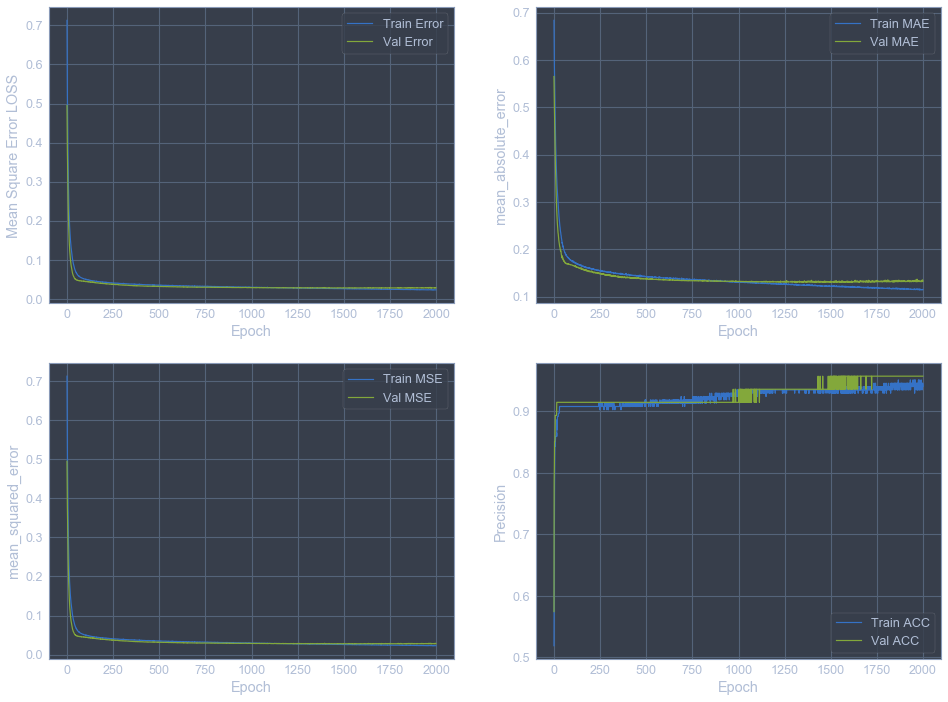

In [72]:
plot_history(history)

Ahora es momento de predecir ya que la red neuronal se encuentra entrenada

In [19]:
y_predic= model.predict(X_test)

Es posible calcular la diferencia entre la prediccion y los datos tomados desde la serie de tiempo

In [20]:
r = y_test - y_predic
ab = abs(r)

Ahora se puede revizar unos datos interesantes

In [21]:
print('Media:', r.mean())
print('Maximo:', ab.max())
print('Minimo:', ab.min())
print('STD:', r.std())

Media: 0.0027376021945802677
Maximo: 0.6669648558108696
Minimo: 0.00035256168547269373
STD: 0.1724262762332611


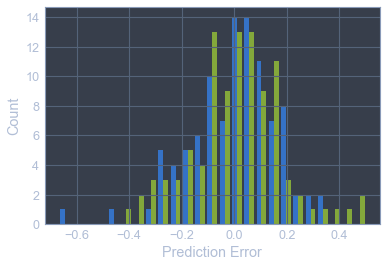

In [22]:
plt.hist(r, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

<h3>Guardar el modelo entrenado </h3>

In [23]:
#model.save('modelo_serie_electrica3.h5')